## Предобработка

In [49]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import random
import copy
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=np.inf) 
selected_words = []


In [50]:
class Data:
    def __init__(self, path='SMS.tsv', sep='\t', header='infer', test_size=0.25):
        self.data = pd.read_csv(path, sep=sep, header=header)
        self.data = self.data.iloc[:2000]    
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.text_train = None
        self.text_test = None 
        self.vectorizer = None
        self.index_to_word = None
        self.word_to_index = None
        self.binary_matrix = None
        self.all_words_list = None
        self.word_to_count = defaultdict(dict)
        self.test_size = test_size
        self.unique_words = None
        self.y_zero_count = 0
        self.y_one_count = 0

    def clear_data(self):
        self.data['text'] = self.data['text'].str.lower()
        self.data['text'] = self.data['text'].apply(
            lambda x: re.sub(r"[^\w\s]|[\d]+|['‘’][a-zA-Z]{1,3}|[a-zA-Z]+\d+|\d+[a-zA-Z]+|[£$€]", "", str(x))
        )
        self.data['class'] = self.data['class'].apply(lambda x: 1 if str(x).strip().lower() == 'spam' else 0)

    def token_data(self):
        self.vectorizer = CountVectorizer()
        sparse_matrix = self.vectorizer.fit_transform(self.data['text'])
        self.binary_matrix = sparse_matrix.toarray()
        self.word_to_index = self.vectorizer.vocabulary_
        self.index_to_word = {index: word for word, index in self.word_to_index.items()}

    def get_word_to_count(self):
        all_words_list = [word for text in self.data['text'] for word in text.split()]
        unique_words, counts = np.unique(all_words_list, return_counts=True)
        self.all_words_list = all_words_list
        self.unique_words = unique_words
        self.word_to_count = dict(zip(unique_words, counts))

    def split_test_and_train(self):
        text_data = self.data['text'].apply(lambda x: x.split()).tolist()
        x_data = self.binary_matrix
        y_data = self.data['class'].tolist()

        split_index = int(len(x_data) * (1 - self.test_size))
        self.x_train, self.x_test = x_data[:split_index], x_data[split_index:]
        self.y_train, self.y_test = y_data[:split_index], y_data[split_index:]
        self.text_train, self.text_test = text_data[:split_index], text_data[split_index:]
    
    def y_count(self):
        self.y_zero_count = sum(1 for y in self.y_train if y == 0)
        self.y_one_count = sum(1 for y in self.y_train if y == 1)
        
    def transform_words(self, x_data, selected_words):
        selected_indices = []
        for w in selected_words:
            selected_indices.append(self.word_to_index[w])                
        
        new_x = x_data[:, selected_indices]
        return new_x


    def get_token_map(self):
        return self.vectorizer.vocabulary_

    def get_token_list(self):
        return self.vectorizer.get_feature_names_out()

    def get_index_to_word(self):
        return self.index_to_word

    def get_word_to_index(self):
        return self.word_to_index

    def return_data(self):
        return self.data


In [51]:
text = Data()
text.clear_data()  
text.token_data()
text.split_test_and_train()
text.get_word_to_count()
text.y_count()
# print(text.y_one_count)
# print(text.y_zero_count)
# print(text.text_train[:3])
# print(text.y_train[:3])
# print(text.x_train[:3])
# print("количество слов :", text.total_words)
# print("количество предложений :", text.total_sentences)
# print(text.data.head())
# print()
# print(text.get_token_map())
# print(text.get_token_list())
# print()
# print(text.binary_matrix[:3]) 

## Выбор признаков

In [52]:
class EmbeddedFeature:
    def __init__(self, x_data, y_data, index_to_word, word_to_index,percent_step = 0.3, min_object_leaf = 50, max_features = 35, max_depth = 10):
        self.percent_step = percent_step
        self.min_object_leaf = min_object_leaf
        self.max_features = max_features
        self.max_depth = max_depth
        self.x_data = x_data
        self.y_data = y_data
        self.index_to_word = index_to_word
        self.word_to_index = word_to_index
        self.main_words = None
        self.model = DecisionTreeClassifier(
            criterion="entropy",  
            max_depth=self.max_depth,
            min_samples_leaf=self.min_object_leaf
        )
        # print(x_data[:3])
        
    def get_features(self):
        cur_words = copy.deepcopy(self.x_data)
        cur_index = np.arange(cur_words.shape[1])
        while cur_words.shape[1] > self.max_features:
            rest_count = int(len(cur_index)*(self.percent_step))
            self.model.fit(cur_words, self.y_data)
            importance = list(zip(cur_index, self.model.feature_importances_))
            importance.sort(key=lambda feature: feature[1])
            delete_importance = importance[:rest_count]
            importance = importance[rest_count:]
            
            delete_indices = [dw[0] for dw in delete_importance]
            keep_mask = ~np.isin(cur_index, delete_indices)
            cur_words = cur_words[:, keep_mask]
            cur_index = cur_index[keep_mask]
        self.main_words = cur_index
    
    def return_main_words(self):
        for word in self.main_words:
            print(self.index_to_word[word])
            

In [53]:
embedded = EmbeddedFeature(text.x_train, text.y_train, text.index_to_word, text.word_to_index)
embedded.get_features()
embedded.return_main_words()
selected_words.append(("EmbeddedFeature",embedded.main_words))

call
have
in
my
the
to
txt
you
your
yourinclusive
yourjob
yours
yourself
youthats
youto
youuuuu
youve
youwhen
yowifes
yoyyooo
yr
yrs
yummy
yun
yuo
yup
ywhere
zahers
zed
zhong
zoe
zouk
üll


In [54]:
class WrapperFeature:
    def __init__(self, x_data, y_data, index_to_word, word_to_index,percent_step = 0.3, min_object_leaf = 50, max_features = 35, max_depth = 10):
        self.percent_step = percent_step
        self.min_object_leaf = min_object_leaf
        self.max_features = max_features
        self.max_depth = max_depth
        self.x_data = x_data
        self.y_data = y_data
        self.index_to_word = index_to_word
        self.word_to_index = word_to_index
        self.main_words = None
        self.model = DecisionTreeClassifier(
            criterion="entropy",  
            max_depth=self.max_depth,
            min_samples_leaf=self.min_object_leaf
        )
    
    def get_features(self):
        chosen_words = []
        set_chosen_words = set()
        while (len(chosen_words) <= self.max_features):
            best_score = -float("inf")
            best_feature = None
            for cur_word in range(self.x_data.shape[1]):
                if cur_word not in set_chosen_words:
                    current_features = chosen_words + [cur_word]
                    new_X = self.x_data[:, current_features]
                    self.model.fit(new_X, self.y_data)
                    score = self.model.score(new_X, self.y_data)
                    if score > best_score:
                        best_score = score
                        best_feature = cur_word
            chosen_words.append(best_feature)
            set_chosen_words.add(best_feature)
        self.main_words = chosen_words
  
    def return_main_words(self):
        for word_idx in self.main_words:
            print(self.index_to_word[word_idx])   
        

In [55]:
# wrapper = WrapperFeature(text.x_train, text.y_train, text.index_to_word, text.word_to_index)
# wrapper.get_features()
# wrapper.return_main_words()
# selected_words.append(("WrapperFeature",wrapper.main_words))

In [56]:
class Correlation:
    def __init__(self, list_sentences, list_obj_vals, max_features, total_sentences, word_to_count):
        self.list_sentences = list_sentences
        self.list_obj_vals = np.array(list_obj_vals)
        self.max_features = max_features
        self.pearson_coeffs = []
        self.total_sentences = total_sentences
        self.word_to_count = word_to_count
        self.y_average = 0
        self.x_average = 0
        self.y_std = 0
        self.x_std = 0
        self._help_init()

    def _help_init(self):
        total_freq = sum(self.get_sum_freq(cur_sent) for cur_sent in self.list_sentences)
        self.x_average = total_freq / self.total_sentences
        self.y_average = np.sum(self.list_obj_vals) / self.total_sentences
        self.y_std = self.calculate_std(self.list_obj_vals)
        sum_x = sum((self.get_sum_freq(cur_sent) - self.x_average) ** 2 for cur_sent in self.list_sentences)
        self.x_std = sqrt(sum_x / self.total_sentences)

    def calculate_std(self, values):
        mean = np.mean(values)
        variance = np.sum((values - mean) ** 2) / len(values)
        return np.sqrt(variance)

    def get_sum_freq(self, sentence):
        return sum(self.word_to_count.get(cur_word, 0) for cur_word in sentence)

    def calculate_pearson_for_message(self, sentence, y):
        x_count = self.get_sum_freq(sentence)
        x_diff = x_count - self.x_average
        y_diff = y - self.y_average
        covariance = (x_diff * y_diff)/self.total_sentences
        if self.x_std == 0 or self.y_std == 0:
            return 0.0

        return covariance / (self.x_std * self.y_std)   

    def calculate_all_pearsons(self):
        for i in range(self.total_sentences):
            cur_sent = self.list_sentences[i]
            y = self.list_obj_vals[i]
            pearson_coeff = self.calculate_pearson_for_message(cur_sent, y)
            self.pearson_coeffs.append((pearson_coeff, cur_sent))

    def get_top_messages(self):
        self.calculate_all_pearsons()
        sorted_pearsons = sorted(self.pearson_coeffs, key=lambda x: x[0], reverse=True)
        top_messages = sorted_pearsons[:self.max_features]
        return [sent for _, sent in top_messages]


In [57]:
class FilterFeature:
    def __init__(self, list_sentences, list_classes, index_to_word, max_features, word_to_count):
        self.max_features = max_features
        self.words = set()
        self.list_sentences = list_sentences
        self.list_classes = list_classes
        self.index_to_word = index_to_word
        self.word_to_count = word_to_count

    def get_features(self):
        correlation = Correlation(self.list_sentences, self.list_classes, self.max_features, len(self.list_sentences), self.word_to_count)
        top_messages = correlation.get_top_messages()
        for sent in top_messages:
            for cur_word in sent:
                if len(self.words) >= self.max_features:
                    break
                self.words.add(cur_word)

        return list(self.words)

In [58]:
filter_feature = FilterFeature(text.text_train, text.y_train, text.index_to_word, 30, text.word_to_count)
selected_words.append(("FilterFeature", filter_feature.get_features()))

## Встроенные методы выбора признаков

In [59]:
class KBeast:
    def __init__(self, x_data, y_data, max_features, index_to_word):
        self.x_data = np.array(x_data) 
        self.y_data = np.array(y_data)  
        self.max_features = max_features 
        self.index_to_word = index_to_word
        self.mask = [] 
        self.best_words = [] 
        self.word_importances = []  

    def get_best(self):
        selector = SelectKBest(score_func=chi2, k=self.max_features)
        selector.fit(self.x_data, self.y_data)        
        self.mask = selector.get_support()        
        selected_indices = np.where(self.mask)[0]
        
        self.best_words = [self.index_to_word[i] for i in selected_indices]

        return self.best_words

In [60]:
kbeast = KBeast(text.x_train, text.y_train, 30, text.index_to_word)
words_k_beast = kbeast.get_best()
selected_words.append(("KBeast",words_k_beast))

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np

class KBeastTree:
    def __init__(self, x_data, y_data, max_features, index_to_word, 
                 max_depth=None, criterion='entropy', min_samples_split=2):
        self.x_data = np.array(x_data)
        self.y_data = np.array(y_data)
        self.max_features = max_features
        self.index_to_word = index_to_word
        self.mask = []
        self.best_words = []
        self.max_depth = max_depth
        self.criterion = criterion
        self.min_samples_split = min_samples_split

    def get_best(self):
        tree = DecisionTreeClassifier(
            max_depth=self.max_depth,
            criterion=self.criterion,
            min_samples_split=self.min_samples_split,
            random_state=0
        )
        tree.fit(self.x_data, self.y_data)
        selector = SelectFromModel(estimator=tree, max_features=self.max_features, prefit=True)
        self.mask = selector.get_support()
        selected_indices = np.where(self.mask)[0]
        self.best_words = [self.index_to_word[i] for i in selected_indices]
        return self.best_words

In [62]:
kbeast = KBeastTree(
    x_data=text.x_train, 
    y_data=text.y_train, 
    max_features=30, 
    index_to_word=text.index_to_word,
    max_depth=10, 
    criterion='entropy', 
    min_samples_split=20
)
best_words_by_sklearn_tree = kbeast.get_best()
selected_words.append(("KBeastTree",best_words_by_sklearn_tree))

In [63]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import numpy as np

class KBeastWrapper:
    def __init__(self, x_data, y_data, max_features, index_to_word):
        self.x_data = np.array(x_data)
        self.y_data = np.array(y_data)
        self.max_features = max_features
        self.index_to_word = index_to_word
        self.best_words = []

    def get_best(self):
        model = LogisticRegression(random_state=0, max_iter=1000)
        selector = RFE(estimator=model, n_features_to_select=self.max_features)
        selector.fit(self.x_data, self.y_data)
        mask = selector.get_support()

        selected_indices = np.where(mask)[0]
        self.best_words = [self.index_to_word[i] for i in selected_indices]

        return self.best_words


In [64]:
# kbeast_wrapper = KBeastWrapper(
#     x_data=text.x_train,
#     y_data=text.y_train,
#     max_features=30,
#     index_to_word=text.index_to_word
# )
# best_words_by_wrapper = kbeast_wrapper.get_best()
# selected_words.append(("KBeastWrapper", best_words_by_wrapper))

In [65]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

class KBeastVarianceThreshold:
    def __init__(self, x_data, max_features, index_to_word, threshold=0.01):
        self.x_data = np.array(x_data)
        self.max_features = max_features
        self.index_to_word = index_to_word
        self.threshold = threshold  
        self.best_words = [] 

    def get_best(self):
        selector = VarianceThreshold(threshold=self.threshold)
        selector.fit(self.x_data)

        variances = selector.variances_  
        sorted_indices = np.argsort(variances)[::-1]
        top_indices = sorted_indices[:self.max_features]

        self.best_words = [self.index_to_word[i] for i in top_indices]

        return self.best_words


In [66]:
kbeast = KBeastVarianceThreshold(
    x_data=text.x_train,
    max_features=30,
    index_to_word=text.index_to_word,
    threshold=0.01
)

best_words = kbeast.get_best()
selected_words.append(("KBeastVarianceThreshold", best_words))

## Выбор лучшей реализации выбора признаков с помощью классификации

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

class Classification:
    def __init__(self, text_data_train, text_data_test, x_train, y_train, x_test, y_test, selected_words, classificator):
        self.text_data_train = text_data_train 
        self.text_data_test = text_data_test  
        self.x_train = x_train              
        self.y_train = y_train                
        self.x_test = x_test                   
        self.y_test = y_test             
        self.selected_words = selected_words    
        self.classificator = classificator   
        self.vectorizer = None               
    
    def classification(self):
        self.vectorizer = CountVectorizer(vocabulary=self.selected_words, binary=True)
        x_train_selected = self.vectorizer.transform(
            [" ".join(words) for words in self.text_data_train]
        ).toarray()
        
        x_test_selected = self.vectorizer.transform(
            [" ".join(words) for words in self.text_data_test]
        ).toarray()
        
        self.classificator.fit(x_train_selected, self.y_train)
        self.y_pred = self.classificator.predict(x_test_selected)
    
    def get_accuracy(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        return accuracy


In [68]:
classifiers = [
    ("DecisionTree", DecisionTreeClassifier()),
    ("LogisticRegression", LogisticRegression()),
    ("RandomForest", RandomForestClassifier(n_estimators=100))
]
best_alg = None
best_accur = float("-inf")
best_new_words = None
for cur_selected_lists in selected_words:
    for cur_classif in classifiers:
        cur_model = Classification(
            text_data_train=text.text_train, 
            text_data_test=text.text_test, 
            x_train=text.x_train, 
            y_train=text.y_train, 
            x_test=text.x_test, 
            y_test=text.y_test, 
            selected_words=cur_selected_lists[1], 
            classificator=cur_classif[1]
        )
        cur_model.classification()
        accur = cur_model.get_accuracy()
        if accur > best_accur:
            best_accur = accur
            best_alg = cur_selected_lists[0]
            best_new_words = cur_selected_lists[1]
        print("классификатор : ", cur_classif[0])
        print("Алгоритм выбора слов : ", cur_selected_lists[0])
        print("Точность классификации : ", accur)
        print()
    print() 

print(best_accur)
print(best_alg)
print(best_new_words)

классификатор :  DecisionTree
Алгоритм выбора слов :  EmbeddedFeature
Точность классификации :  0.87

классификатор :  LogisticRegression
Алгоритм выбора слов :  EmbeddedFeature
Точность классификации :  0.87

классификатор :  RandomForest
Алгоритм выбора слов :  EmbeddedFeature
Точность классификации :  0.87


классификатор :  DecisionTree
Алгоритм выбора слов :  FilterFeature
Точность классификации :  0.904

классификатор :  LogisticRegression
Алгоритм выбора слов :  FilterFeature
Точность классификации :  0.91

классификатор :  RandomForest
Алгоритм выбора слов :  FilterFeature
Точность классификации :  0.9


классификатор :  DecisionTree
Алгоритм выбора слов :  KBeast
Точность классификации :  0.962

классификатор :  LogisticRegression
Алгоритм выбора слов :  KBeast
Точность классификации :  0.96

классификатор :  RandomForest
Алгоритм выбора слов :  KBeast
Точность классификации :  0.956


классификатор :  DecisionTree
Алгоритм выбора слов :  KBeastTree
Точность классификации :  0

## K_Means

In [100]:
from matplotlib.lines import Line2D


class K_Maens:
    def __init__(self, max_iters, clusters, x_data, y_data, y_one, y_zero):
        self.max_iters = max_iters
        self.clusters = clusters
        self.cluster_to_points = [[] for _ in range(self.clusters)]
        self.homogeneity_value = 0
        self.silhouette_mean = 0
        self.centroid = []
        self.x_data = x_data
        self.y_data = y_data
        self.y_one = y_one
        self.y_zero = y_zero
        self.count_obj = len(x_data)
    
    ## инициализация центроидов    
    def get_centroids(self):
        first_index = random.choice(range(len(self.x_data)))  
        self.centroid.append(self.x_data[first_index])
        while len(self.centroid) < self.clusters:
            probs = self.get_probabilities()
            next_index = np.random.choice(range(len(self.x_data)), 1, p=probs)[0]
            if any(np.array_equal(self.x_data[next_index], c) for c in self.centroid):
                continue
            self.centroid.append(self.x_data[next_index])

    def get_probabilities(self):
        dists = self.get_dists_to_nearest_centroid()
        total_distance = sum(dists)
        probs = [dist / total_distance for dist in dists]
        return probs

    def get_dists_to_nearest_centroid(self):
        dists = [float('inf')] * len(self.x_data)
        for cur_centroid in self.centroid:
            for pos, cur_point in enumerate(self.x_data):
                cur_dist = np.sqrt(np.sum((cur_point - cur_centroid) ** 2))
                if cur_dist < dists[pos]:
                    dists[pos] = cur_dist
        return dists
    
    
    ## обновляю принадлежность точки до центроида. ищу расстояние до ближайшего центроида и соответствующем кластеру добавляю ее
    def update_cluster_to_points(self):
        self.cluster_to_points = [[] for _ in range(self.clusters)]
        for point_idx, cur_point in enumerate(self.x_data):
            closest_centroid_idx = self.nearest_centr_to_point(cur_point, self.centroid)[0]
            self.cluster_to_points[closest_centroid_idx].append(point_idx)

    def nearest_centr_to_point(self, cur_point, centroids):
        dists = []
        for pos, cur_centr in enumerate(centroids):
            cur_dist = np.sqrt(np.sum((cur_point - cur_centr) ** 2))
            dists.append((pos, cur_dist))  
        
        sorted_dists = sorted(dists, key=lambda x: x[1])
        sorted_indices = [idx for idx, _ in sorted_dists]  
        
        return sorted_indices
    
    ## обновляю центроиды
    def update_centroids(self):
        new_centroids = []
        for cluster in self.cluster_to_points:
            new_centroids.append(self._get_centroid(cluster))
        self.centroid = new_centroids
        
    def _get_centroid(self, cluster):
        if len(cluster) == 0:
            return self.x_data[random.randint(0, len(self.x_data)-1)]
        return np.mean(self.x_data[cluster], axis=0)
    
        
    ## вычисляю расстояния между новыми и старыми центроидами, если расстояния слишком маленькие, останавливаю алгоритм
    def dists_between_centroids(self, old_cent, new_centr):
        dists = []
        for pos, cur_centr in enumerate(old_cent):
            cur_dist = np.sqrt(np.sum((cur_centr - new_centr[pos])**2))
            dists.append(cur_dist)
        return dists

    ## кластеризация    
    def fit(self):
        self.get_centroids()
        for iteration in range(self.max_iters):
            old_centroids = [c.copy() for c in self.centroid]  
            self.update_cluster_to_points()  
            self.update_centroids()  

            new_centroids = self.centroid
            centroid_shifts = self.dists_between_centroids(old_centroids, new_centroids)
            max_shift = max(centroid_shifts) if centroid_shifts else 0
            print(f"Iteration {iteration}, Max centroid shift: {max_shift}")
            if max_shift < 1e-4: 
                print("Converged")
                break
         
    # оценки и графики          
    def silhouette(self):
        silhouette_scores = []
        for cluster in self.cluster_to_points:
            for point_idx in cluster:
                sent = self.x_data[point_idx]
                inside = self.get_mean_dist_inside_cluster(sent, cluster)                
                between = self.get_mean_dist_betw_point_and_cluster(sent)                
                s_i = (between - inside) / max(inside, between)
                silhouette_scores.append(s_i)
        
        self.silhouette_mean = np.mean(silhouette_scores)
        return self.silhouette_mean

    
    def get_mean_dist_inside_cluster(self, sent, cluster):
        if len(cluster) <= 1:
            return 0 
        sum_dist = 0
        for point_idx in cluster:
            cur_sent = self.x_data[point_idx]
            if not np.array_equal(cur_sent, sent):
                sum_dist += np.sqrt(np.sum((cur_sent - sent) ** 2))
        return sum_dist / (len(cluster) - 1)

    
    def get_mean_dist_betw_point_and_cluster(self, sent):
        sorted_centroids = self.nearest_centr_to_point(sent, self.centroid)
        nearest_idx = sorted_centroids[1]  
        other_cluster = self.cluster_to_points[nearest_idx]
        dists = [
            np.sqrt(np.sum((self.x_data[idx] - sent) ** 2))
            for idx in other_cluster
        ]
        return np.mean(dists)


    ## гомогенность
    def homogeneity(self):
        count_zero_and_one = [self.y_zero, self.y_one]  
        h_class = -sum(
            (count / self.count_obj) * np.log(count / self.count_obj)
            for count in count_zero_and_one if count > 0
        )

        h_class_cluster = 0.0

        for cluster in self.cluster_to_points:
            cluster_size = len(cluster) 

            num_zero = sum(self.y_data[idx] == 0 for idx in cluster)
            num_one  = cluster_size - num_zero

            cluster_entropy = 0.0
            for count_in_class in [num_zero, num_one]:
                if count_in_class > 0:
                    p_c_given_k = count_in_class / cluster_size
                    p_k = count_in_class/self.count_obj
                    cluster_entropy -= p_k * np.log(p_c_given_k)

            h_class_cluster += (cluster_size / self.count_obj) * cluster_entropy

        homogeneity = 1.0 - h_class_cluster / h_class
        self.homogeneity_value = homogeneity

        return homogeneity

    def plot(self, name):
        _, ax = plt.subplots(figsize=(12, 9))  

        palette = sns.color_palette("hls", self.clusters * 2)

        for cluster_idx, point_indices in enumerate(self.cluster_to_points):
            points_class_0 = [idx for idx in point_indices if self.y_data[idx] == 0]
            points_class_1 = [idx for idx in point_indices if self.y_data[idx] == 1]

            cluster_points_0 = self.x_data[points_class_0]
            ax.scatter(
                cluster_points_0[:, 0], 
                cluster_points_0[:, 1], 
                color=palette[cluster_idx * 2], 
                marker='o',  
                alpha=0.7, 
                label=f"Cluster {cluster_idx}, Class 0"
            )

            cluster_points_1 = self.x_data[points_class_1]
            ax.scatter(
                cluster_points_1[:, 0], 
                cluster_points_1[:, 1], 
                color=palette[cluster_idx * 2 + 1],  
                marker='s',  
                alpha=0.7,  
                label=f"Cluster {cluster_idx}, Class 1"
            )

        centroids_arr = np.array(self.centroid)
        ax.scatter(
            centroids_arr[:, 0],
            centroids_arr[:, 1],
            marker="x",
            s=300,  
            linewidths=3,
            color="black",
            label="Centroids"
        )

        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)

        legend_markers = [
            Line2D([0], [0], color=palette[i], marker='o' if i % 2 == 0 else 's', linestyle='', label=f"Cluster {i//2}, Class {i%2}")
            for i in range(self.clusters * 2)
        ]   
        legend_markers.append(Line2D([0], [0], color="black", marker="x", linestyle='', label="Centroids"))
        
        ax.legend(handles=legend_markers)
        ax.set_title(f"K-Means Clusters {name}")
        plt.tight_layout()
        plt.show()


In [98]:
k_means = K_Means(250, 2, text.x_train, text.y_train, text.y_one_count, text.y_zero_count)
k_means.fit()
print(k_means.silhouette())
print(k_means.homogeneity())

Iteration 0, Max centroid shift: 4.835905049266564
Iteration 1, Max centroid shift: 0.4692897915413359
Iteration 2, Max centroid shift: 0.2794041514028122
Iteration 3, Max centroid shift: 0.2413077922310217
Iteration 4, Max centroid shift: 0.22968206316433556
Iteration 5, Max centroid shift: 0.30881638501860137
Iteration 6, Max centroid shift: 0.41838989628337964
Iteration 7, Max centroid shift: 0.48238565507976516
Iteration 8, Max centroid shift: 0.3949389105095141
Iteration 9, Max centroid shift: 0.22375573827387102
Iteration 10, Max centroid shift: 0.13526564164632301
Iteration 11, Max centroid shift: 0.09748950271419057
Iteration 12, Max centroid shift: 0.07612282966711949
Iteration 13, Max centroid shift: 0.043670409384649576
Iteration 14, Max centroid shift: 0.009897211528251086
Iteration 15, Max centroid shift: 0.01695720981108637
Iteration 16, Max centroid shift: 0.01754062254283871
Iteration 17, Max centroid shift: 0.0
Converged
0.18433857055438174
0.3599071203758709


## PCA

In [73]:
class PCA:
    def __init__(self, k, x_data):
        self.k = k 
        self.matrix = np.array(x_data)
        self.mean = None 
        self.components = None 
        self.explained_variance = None  
    
    def calculate(self):
        self.mean = np.mean(self.matrix, axis=0)
        centered_matrix = self.matrix - self.mean 
        n_samples = centered_matrix.shape[0]       
        _, S, VT = np.linalg.svd(centered_matrix, full_matrices=False)        
        self.components = VT[:self.k, :].T        
        self.explained_variance = (S ** 2) / (n_samples - 1)        
        reduced_data = np.dot(centered_matrix, self.components)
        return reduced_data
    
    def get_explained_variance_ratio(self):
        total_variance = np.sum(self.explained_variance)
        return self.explained_variance[:self.k] / total_variance

    def reconstruct(self, reduced_data):
        return np.dot(reduced_data, self.components.T) + self.mean


In [74]:
pca = PCA(2, text.x_train)
new_messages = pca.calculate()
print(pca.get_explained_variance_ratio())

[0.05703808 0.03511804]


## TSNE

In [77]:
from sklearn.manifold import TSNE
import numpy as np

class TSNEEmbedding:
    def __init__(self, k, x_data, max_iter=1000):
        self.k = k 
        self.matrix = np.array(x_data) 
        self.max_iter = max_iter
        self.embedding = None  

    def calculate(self):
        tsne = TSNE(
            n_components=self.k,
            max_iter=self.max_iter,
            random_state=0
        )
        self.embedding = tsne.fit_transform(self.matrix)
        return self.embedding


In [78]:
tsne = TSNEEmbedding(k=2, x_data=text.x_train, max_iter=250)
reduced_data = tsne.calculate()
reduced_data

array([[ 4.18795645e-02,  5.19755036e-02],
       [ 6.39529377e-02,  5.03716208e-02],
       [ 5.61526455e-02,  2.70497277e-02],
       [ 3.98940891e-02, -4.58529592e-02],
       [ 3.57272625e-02,  4.48982902e-02],
       [ 6.16778620e-02,  2.72198059e-02],
       [ 4.89862040e-02,  3.24051976e-02],
       [ 4.90192175e-02,  3.38673443e-02],
       [ 5.60628846e-02,  2.18635723e-02],
       [ 5.76903075e-02,  2.60915328e-02],
       [ 5.12027964e-02, -4.16374616e-02],
       [ 5.49404100e-02,  2.95436718e-02],
       [ 5.67289367e-02,  2.15671305e-02],
       [ 5.38890734e-02,  2.42960975e-02],
       [ 5.07553369e-02,  3.43109183e-02],
       [ 5.29849157e-02,  3.50407809e-02],
       [ 4.65177558e-02,  3.57682109e-02],
       [ 3.18670385e-02,  5.20271175e-02],
       [ 5.25866970e-02,  4.03101295e-02],
       [ 5.35006076e-02,  2.90292762e-02],
       [ 4.30884585e-02,  3.84498984e-02],
       [ 4.57741246e-02, -2.41822153e-02],
       [ 3.60717103e-02,  5.62620237e-02],
       [ 4.

## Кластеризация с выбором признаков

In [75]:
new_x_data = text.transform_words(text.x_train, best_new_words)
print(new_x_data[:1])
k_means = K_Means(
    max_iters=100,
    clusters=2,
    x_data=new_x_data,        
    y_data = text.y_train,
    y_one= text.y_one_count, 
    y_zero= text.y_zero_count
)

k_means.fit()

print("Homogeneity:", k_means.homogeneity())
print("Silhouette:", k_means.silhouette())

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Iteration 0, Max centroid shift: 0.49971314108128945
Iteration 1, Max centroid shift: 0.0
Converged
Homogeneity: 0.5451529860929409
Silhouette: 0.45008629871910594


## Кластеризация с понижением размерности

Shape of reduced_data: (1500, 2)
Iteration 0, Max centroid shift: 57.99102020263672
Iteration 1, Max centroid shift: 57.991024017333984
Iteration 2, Max centroid shift: 0.0
Converged
1500
Cluster 0: 1499 points
Cluster 1: 1 points


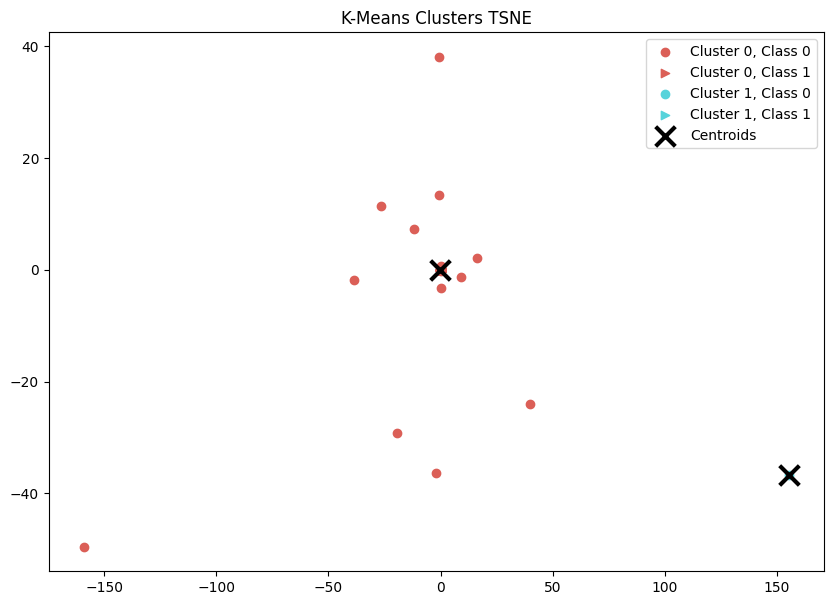

0.0009175520287901806
0.9964635


In [79]:
print("Shape of reduced_data:", reduced_data.shape)

k_means_tsne = K_Means(
    max_iters=100,
    clusters=2,
    x_data=reduced_data,  
    y_data = text.y_train,
    y_one= text.y_one_count, 
    y_zero= text.y_zero_count
)
k_means_tsne.fit()

print(sum(len(cluster) for cluster in k_means_tsne.cluster_to_points))
for idx, cluster in enumerate(k_means_tsne.cluster_to_points):
    print(f"Cluster {idx}: {len(cluster)} points")
k_means_tsne.plot("TSNE") 
print(k_means_tsne.homogeneity())
print(k_means_tsne.silhouette())


Iteration 0, Max centroid shift: 0.22392706330069231
Iteration 1, Max centroid shift: 0.04787158869176379
Iteration 2, Max centroid shift: 0.0
Converged
1500
Cluster 0: 1023 points
Cluster 1: 477 points


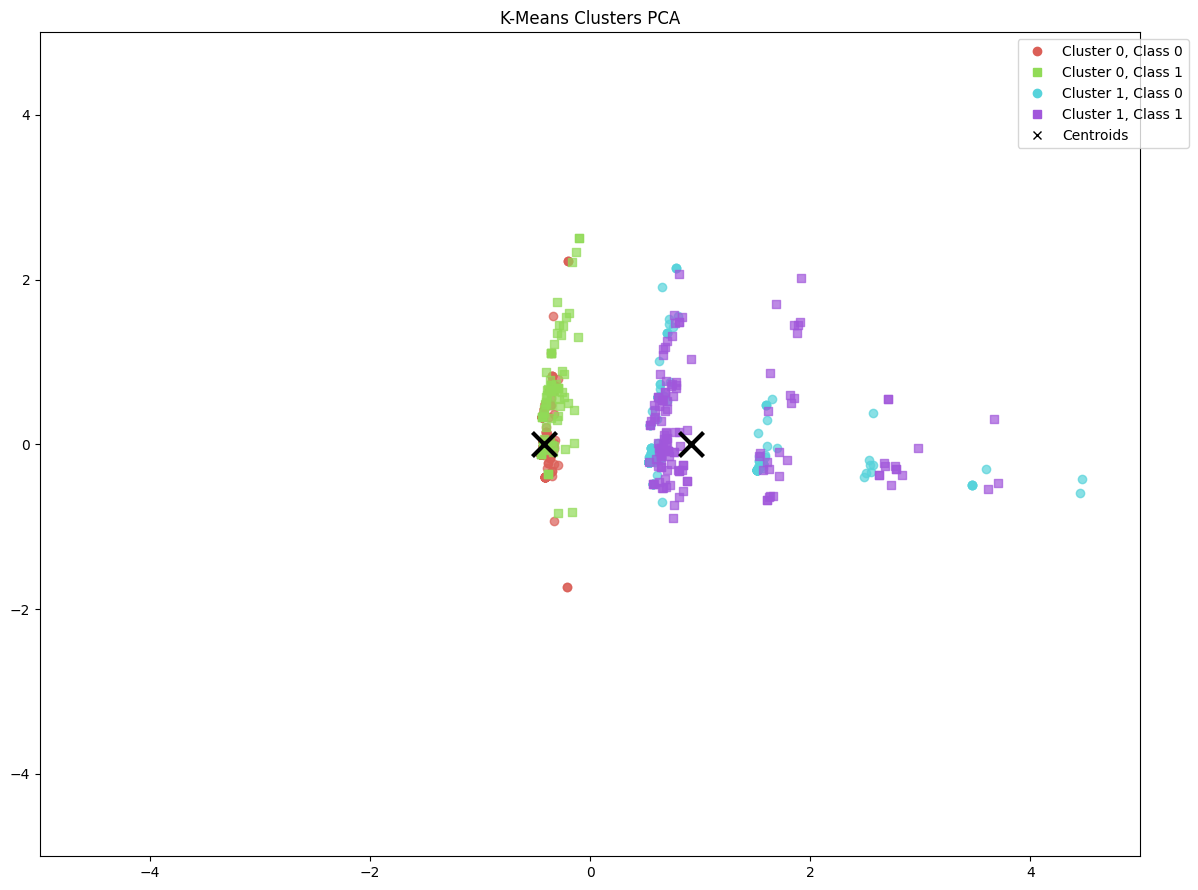

0.5451529860929409
0.689406366521666


In [99]:
k_means_pca = K_Means(
    max_iters=100,
    clusters=2,         
    x_data=new_messages,  
    y_data=text.y_train,  
    y_one=text.y_one_count,
    y_zero=text.y_zero_count
)

k_means_pca.fit()
print(sum(len(cluster) for cluster in k_means_pca.cluster_to_points))
for idx, cluster in enumerate(k_means_pca.cluster_to_points):
    print(f"Cluster {idx}: {len(cluster)} points")

k_means_pca.plot("PCA")
print(k_means_pca.homogeneity())
print(k_means_pca.silhouette())


## PCA и выбор признаков

Iteration 0, Max centroid shift: 0.4363386156160527
Iteration 1, Max centroid shift: 0.0
Converged
1500
Cluster 0: 1023 points
Cluster 1: 477 points


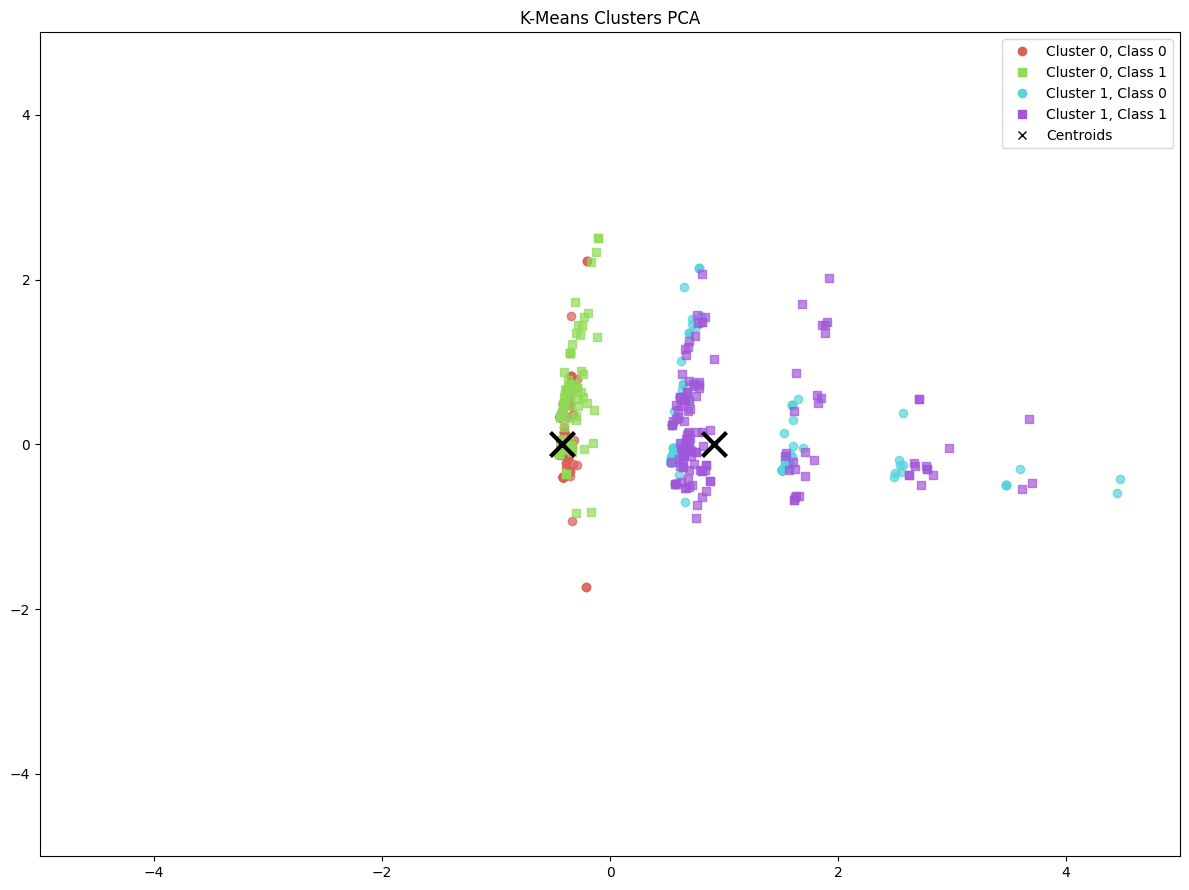

0.5451529860929409
0.689406366521666
[0.33165093 0.10496386]


In [101]:
new_x_data = text.transform_words(text.x_train, best_new_words)
pca = PCA(2, new_x_data)
new_messages = pca.calculate()
ans = pca.get_explained_variance_ratio()
k_means_pca = K_Means(
    max_iters=100,
    clusters=2,         
    x_data=new_messages,  
    y_data=text.y_train,  
    y_one=text.y_one_count,
    y_zero=text.y_zero_count
)

k_means_pca.fit()
print(sum(len(cluster) for cluster in k_means_pca.cluster_to_points))
for idx, cluster in enumerate(k_means_pca.cluster_to_points):
    print(f"Cluster {idx}: {len(cluster)} points")

k_means_pca.plot("PCA")
print(k_means_pca.homogeneity())
print(k_means_pca.silhouette())
print(ans)